## **ResNet50中药炮制饮片质量判断**
### **背景介绍**
中药炮制是根据中医药理论，依照临床辨证施治用药的需要和药物自身性质，以及调剂、制剂的不同要求，**将中药材制备成中药饮片所采取的一项制药技术**。平时我们老百姓能接触到的中药，主要指自己回家煎煮或者请医院代煎煮的中药，都是中药饮片，也就是中药炮制这个技术的结果。而中药炮制饮片，大部分涉及到水火的处理，一定需要讲究“程度适中”，炮制火候不够达不到最好药效，炮制火候过度也会丧失药效。
- “生品”一般是指仅仅采用简单净选得到的饮片，通常没有经过火的处理，也是后续用火加工的原料。
- “不及”就是“炮制不到位”，没有达到规定的程度，饮片不能发挥最好的效果。
- “适中”是指炮制程度刚刚好，正是一个最佳的炮制点位，也是通常炮制结束的终点。
- “太过”是指炮制程度过度了，超过了“适中”的最佳状态，这时候的饮片也会丧失药效，不能再使用了。

过去的炮制饮片程度的判断，都是采用的老药工经验判断，但随着老药工人数越来越少，这种经验判断可能存在“失传”的风险。而随着人工智能的发展，使用深度神经网络模型对饮片状态进行判断能达到很好的效果，可以很好的实现经验的“智能化”和经验的传承。

#### **ResNet网络简介**
ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。<br>
<img src="../7.案例中使用的图片/image-20230804110559.png" alt="image-20230630102435999" style="zoom:30%;" width="60%" />

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。<br>
<img src="../7.案例中使用的图片/image-20230804110625.png" alt="image-20230630102435999" style="zoom:30%;" width="40%" />




### **准备阶段**
#### **配置实验环境**
本案例支持在Ascend平台运行：
- 平台：华为启智平台调试任务
- 框架：MindSpore1.8.1
- 硬件NPU：Ascend 910

#### **数据集介绍**

我们使用“中药炮制饮片”数据集，该数据集由成都中医药大学提供，共包含中药炮制饮片的 3 个品种，分别为：蒲黄、山楂、王不留行，每个品种又有着4种炮制状态：生品、不及适中、太过，每类包含 500 张图片共12类5000张图片，图片尺寸为 4K，图片格式为 jpg。
下面是数据集中的一些样例图片：

<img src="../7.案例中使用的图片/image-20230508160428881.png" alt="image-20230630102435999" style="zoom:67%;" width="90%"/>

#### **准备数据**
我们使用的数据集在调试任务中配置加载，并修改代码中对应url链接。

In [1]:
from download import download
import os
url = "https://open-data.obs.cn-south-222.ai.pcl.cn:443/attachment/7/0/7009e8dc-af94-4f50-afae-0a68fa7db3ee/zhongyiyao.zip?response-content-disposition=attachment%3B+filename%3D%22zhongyiyao.zip%22&AWSAccessKeyId=ZSCXA9TLRN1USYWIF7A5&Expires=1691206985&Signature=tThPGZ10b1lEY2Hqi0qs03z3P5M%3D"
# 创建的是调试任务，url修改为数据集上传生成的url链接
if not os.path.exists("dataset"):
    download(url, "dataset", kind="zip")

Creating data folder...

file_sizes: 100%|███████████████████████████| 16.6G/16.6G [01:05<00:00, 252MB/s]
Extracting zip file...
Successfully downloaded / unzipped to dataset


#### **数据预处理**
原图片尺寸为4k比较大，我们预处理将图片resize到指定尺寸。

In [2]:
from PIL import Image
import numpy as np
data_dir = "dataset/zhongyiyao"
new_data_path = "dataset1/zhongyiyao"
if not os.path.exists(new_data_path):
    for path in ['train','test']:
        data_path = data_dir + "/" + path
        classes = os.listdir(data_path)
        for (i,class_name) in enumerate(classes):
            floder_path =  data_path+"/"+class_name
            print(f"正在处理{floder_path}...")
            for image_name in os.listdir(floder_path):
                try:
                    image = Image.open(floder_path + "/" + image_name)
                    image = image.resize((1000,1000))
                    target_dir = new_data_path+"/"+path+"/"+class_name
                    if not os.path.exists(target_dir):
                        os.makedirs(target_dir)
                    if not os.path.exists(target_dir+"/"+image_name):
                        image.save(target_dir+"/"+image_name)
                except:
                    pass     

正在处理dataset/zhongyiyao/train/wblx_tg...
正在处理dataset/zhongyiyao/train/ph_tg...
正在处理dataset/zhongyiyao/train/ph_bj...
正在处理dataset/zhongyiyao/train/sz_tg...
正在处理dataset/zhongyiyao/train/ph_sz...
正在处理dataset/zhongyiyao/train/sz_sp...
正在处理dataset/zhongyiyao/train/sz_bj...
正在处理dataset/zhongyiyao/train/wblx_sp...
正在处理dataset/zhongyiyao/train/sz_sz...
正在处理dataset/zhongyiyao/train/wblx_sz...
正在处理dataset/zhongyiyao/train/wblx_bj...
正在处理dataset/zhongyiyao/train/ph_sp...
正在处理dataset/zhongyiyao/test/wblx_tg...
正在处理dataset/zhongyiyao/test/ph_tg...
正在处理dataset/zhongyiyao/test/ph_bj...
正在处理dataset/zhongyiyao/test/sz_tg...
正在处理dataset/zhongyiyao/test/ph_sz...
正在处理dataset/zhongyiyao/test/sz_sp...
正在处理dataset/zhongyiyao/test/sz_bj...
正在处理dataset/zhongyiyao/test/wblx_sp...
正在处理dataset/zhongyiyao/test/sz_sz...
正在处理dataset/zhongyiyao/test/wblx_sz...
正在处理dataset/zhongyiyao/test/wblx_bj...
正在处理dataset/zhongyiyao/test/ph_sp...


#### **数据集划分**
数据集已划分为训练集和测试集，可以接着继续划分验证集。

In [3]:
from sklearn.model_selection import train_test_split
import shutil

def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    This function splits the data into training, validation, and test sets.
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


data_dir = "dataset1/zhongyiyao"
floders = os.listdir(data_dir)
target = ['train','test','valid']
if set(floders) == set(target):
    # 如果已经划分则跳过
    pass
elif 'train' in floders:
    # 如果已经划分了train，test，那么只需要从train里边划分出valid
    floders = os.listdir(data_dir)
    new_data_dir = os.path.join(data_dir,'train')
    classes = os.listdir(new_data_dir)
    if '.ipynb_checkpoints' in classes:
        classes.remove('.ipynb_checkpoints')
    imgs = []
    labels = []
    for (i,class_name) in enumerate(classes):
        new_path =  new_data_dir+"/"+class_name
        for image_name in os.listdir(new_path):
            imgs.append(image_name)
            labels.append(class_name)
    imgs_train,imgs_val,labels_train,labels_val = X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)
    print("划分训练集图片数：",len(imgs_train))
    print("划分验证集图片数：",len(imgs_val))
    target_data_dir = os.path.join(data_dir,'valid')
    if not os.path.exists(target_data_dir):
        os.mkdir(target_data_dir)
    for (img,label) in zip(imgs_val,labels_val):
        source_path = os.path.join(data_dir,'train',label)
        target_path = os.path.join(data_dir,'valid',label)
        if not os.path.exists(target_path):
            os.mkdir(target_path)
        source_img = os.path.join(source_path,img)
        target_img = os.path.join(target_path,img)
        shutil.move(source_img,target_img)
else:
    phones = os.listdir(data_dir)
    imgs = []
    labels = []
    for phone in phones:
        phone_data_dir = os.path.join(data_dir,phone)
        yaowu_list = os.listdir(phone_data_dir)
        for yaowu in yaowu_list:
            yaowu_data_dir = os.path.join(phone_data_dir,yaowu)
            chengdu_list = os.listdir(yaowu_data_dir)
            for chengdu in chengdu_list:
                chengdu_data_dir = os.path.join(yaowu_data_dir,chengdu)
                for img in os.listdir(chengdu_data_dir):
                    imgs.append(img)
                    label = ' '.join([phone,yaowu,chengdu])
                    labels.append(label)
    imgs_train, imgs_val, imgs_test, labels_train, labels_val, labels_test = split_data(imgs, labels, test_size=0.2, val_size=0.2, random_state=42)
    img_label_tuple_list = [(imgs_train,labels_train),(imgs_val,labels_val),(imgs_test,labels_test)]
    for (i,split) in enumerate(spilits):
        target_data_dir = os.path.join(data_dir,split)
        if not os.path.exists(target_data_dir):
            os.mkdir(target_data_dir)
        imgs_list,labels_list = img_label_tuple_list[i]
        for (img,label) in zip(imgs_list,labels_list):
            label_split = label.split(' ')
            source_img = os.path.join(data_dir,label_split[0],label_split[1],label_split[2],img)
            target_img_dir = os.path.join(target_data_dir,label_split[1]+"_"+label_split[2])
            if not os.path.exists(target_img_dir):
                os.mkdir(target_img_dir)
            target_img = os.path.join(target_img_dir,img)
            shutil.move(source_img,target_img)
    

划分训练集图片数： 4412
划分验证集图片数： 1104


#### **定义数据加载方式**
通过重写Iterable类的方式加载图片数据集，支持单张图片和文件夹进行加载。

In [4]:
from mindspore.dataset import GeneratorDataset
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype
# 注意没有使用Mindspore提供的ImageFloder进行加载，原因是调试任务中'.ipynb_checkpoints'缓存文件夹会被当作类文件夹进行识别，导致数据集加载错误
class Iterable:
    def __init__(self,data_path):
        self._data = []
        self._label = []
        self._error_list = []
        if data_path.endswith(('JPG','jpg','png','PNG')):
            # 用作推理，所以没有label
            image = Image.open(data_path)
            self._data.append(image)
            self._label.append(0)
        else:
            classes = os.listdir(data_path)
            if '.ipynb_checkpoints' in classes:
                classes.remove('.ipynb_checkpoints')
            for (i,class_name) in enumerate(classes):
                new_path =  data_path+"/"+class_name
                for image_name in os.listdir(new_path):
                    try:
                        image = Image.open(new_path + "/" + image_name)
                        self._data.append(image)
                        self._label.append(i)
                    except:
                        pass
                

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)
    
    def get_error_list(self,):
        return self._error_list
    
def create_dataset_zhongyao(dataset_dir,usage,resize,batch_size,workers):
    data = Iterable(dataset_dir)
    data_set = GeneratorDataset(data,column_names=['image','label'])
    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop(700, (4, 4, 4, 4)),
            # 这里随机裁剪尺度可以设置
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize((resize,resize)),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)
    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    data_set = data_set.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size,drop_remainder=True)

    return data_set

#### **加载数据**
对数据集使用定义好的方式进行加载。

In [5]:
import mindspore as ms
import random
data_dir = "dataset1/zhongyiyao"
train_dir = data_dir+"/"+"train"
valid_dir = data_dir+"/"+"valid"
test_dir = data_dir+"/"+"test"
batch_size = 32 # 批量大小
image_size = 224 # 训练图像空间大小
workers = 4 # 并行线程个数
num_classes = 12 # 分类数量


# 设置随机种子，使得模型结果复现
seed = 42
ms.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

dataset_train = create_dataset_zhongyao(dataset_dir=train_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_zhongyao(dataset_dir=valid_dir,
                                     usage="valid",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
dataset_test = create_dataset_zhongyao(dataset_dir=test_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

print(f'训练集数据：{dataset_train.get_dataset_size()*batch_size}\n')
print(f'验证集数据：{dataset_val.get_dataset_size()*batch_size}\n')
print(f'测试集数据：{dataset_test.get_dataset_size()*batch_size}\n')

训练集数据：4384

验证集数据：1088

测试集数据：576



#### **类别标签说明**
由于平台字体问题，无法正确显示中文，这里给出英文标签对应的类别：
- ph-sp：蒲黄-生品
- ph_bj：蒲黄-不及
- ph_sz：蒲黄-适中
- ph_tg：蒲黄-太过
- sz_sp：山楂-生品
- sz_bj：山楂-不及
- sz_sz：山楂-适中
- sz_tg：山楂-太过
- wblx_sp：王不留行-生品
- wblx_bj：王不留行-不及
- wblx_sz：王不留行-适中
- wblx_tg：王不留行-太过

In [6]:
#index_label的映射
index_label_dict = {}
classes = os.listdir(train_dir)
if '.ipynb_checkpoints' in classes:
    classes.remove('.ipynb_checkpoints')
for i,label in enumerate(classes):
    index_label_dict[i] = label
label2chin = {'ph_sp':'蒲黄-生品',  'ph_bj':'蒲黄-不及', 'ph_sz':'蒲黄-适中', 'ph_tg':'蒲黄-太过', 'sz_sp':'山楂-生品',
              'sz_bj':'山楂-不及', 'sz_sz':'山楂-适中', 'sz_tg':'山楂-太过', 'wblx_sp':'王不留行-生品', 'wblx_bj':'王不留行-不及',
              'wblx_sz':'王不留行-适中', 'wblx_tg':'王不留行-太过'}
index_label_dict

{0: 'wblx_tg',
 1: 'ph_tg',
 2: 'ph_bj',
 3: 'sz_tg',
 4: 'ph_sz',
 5: 'sz_sp',
 6: 'sz_bj',
 7: 'wblx_sp',
 8: 'sz_sz',
 9: 'wblx_sz',
 10: 'wblx_bj',
 11: 'ph_sp'}

#### **数据可视化展示**
对已经加载好的数据集，选取部分数据展示。

In [7]:
import matplotlib.pyplot as plt
plt.rc('font',family='YouYuan')
import numpy as np

data_iter = next(dataset_val.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")


Image shape: (32, 3, 224, 224), Label: [ 5  7 11  7  8 11  4  8  1  5  2  7  4  0  1 10  1  4  3  6  2  6  3 10
  6  3  7  7  3  1  9  3]


findfont: Font family ['YouYuan'] not found. Falling back to DejaVu Sans.


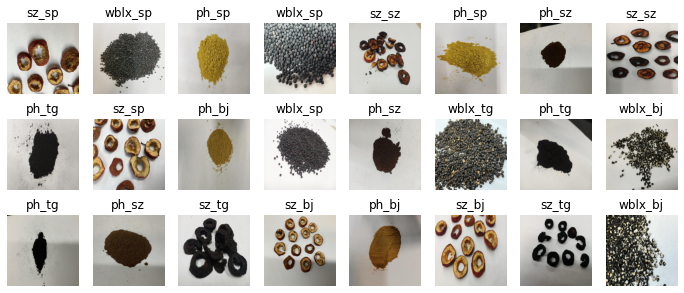

In [8]:
# 设置中文
plt.figure(figsize=(12, 5))
for i in range(24):
    plt.subplot(3, 8, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(index_label_dict[labels[i]])
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

### **创建分类网络**
当处理完数据后，就可以来进行网络的搭建了。我们使用经典的Resnet50作为基础模型，模型由MindSpore框架编写，我们在此基础上进行了修改，将最后一层的输出改为类别数12，以适应我们的数据集。

#### **模型结构展示**

<img src="../7.案例中使用的图片/image-20230630095910087.png" alt="image-20230630095910087" style="zoom:80%;" />

#### **构建残差网络结构**
残差结构是ResNet网络中最重要的结构，其结构图如下图所示，残差网络由两个分支构成：一个主分支，一个shortcuts（图中弧线表示）。主分支通过堆叠一系列的卷积操作得到，shortcuts从输入直接到输出，主分支的输出与shortcuts的输出相加后通过Relu激活函数后即为残差网络最后的输出。<br>
<img src="../7.案例中使用的图片/image-20230804113155.png" alt="image-20230630102435999" style="zoom:67%;" width="40%"/>

残差网络结构主要由两种，一种是Building Block，适用于较浅的ResNet网络，如ResNet18和ResNet34；另一种是Bottleneck，适用于层数较深的ResNet网络，如ResNet50、ResNet101和ResNet152。

#### **定义 Building Block**
Building Block结构图如下图所示，主分支有两层卷积网络结构：

- 主分支第一层网络以输入channel为64为例，首先通过一个3×3的卷积层，然后通过Batch Normalization层，最后通过Relu激活函数层，输出channel为64；

- 主分支第二层网络的输入channel为64，首先通过一个3×3的卷积层，然后通过Batch Normalization层，输出channel为64。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Building Block最后的输出。<br>
<img src="../7.案例中使用的图片/image-20230804114627.png" alt="image-20230630102435999" style="zoom:67%;" width="30%" />

In [9]:
from mindspore import Model
from mindspore import context
import mindspore.ops as ops
from mindspore import Tensor, nn, set_context, GRAPH_MODE, train
from mindspore import load_checkpoint, load_param_into_net
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal


weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


#### **定义 Bottleneck**
Bottleneck结构图如下图所示，在输入相同的情况下Bottleneck结构相对Building Block结构的参数数量更少，更适合层数较深的网络，ResNet50使用的残差结构就是Bottleneck。该结构的主分支有三层卷积结构，分别为1×1的卷积层、3×3卷积层和
1×1的卷积层，其中1×1的卷积层分别起降维和升维的作用。

- 主分支第一层网络以输入channel为256为例，首先通过数量为64，大小为的卷积核进行降维，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；

- 主分支第二层网络通过数量为64，大小为的卷积核提取特征，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；

- 主分支第三层通过数量为256，大小的卷积核进行升维，然后通过Batch Normalization层，其输出channel为256。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Bottleneck最后的输出。<br>
<img src="../7.案例中使用的图片/image-20230804115129.png" alt="image-20230630102435999" style="zoom:67%;" width="30%"/>

In [10]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

#### **构建ResNet网络**
ResNet网络由基本的Building Block/Bottleneck块堆叠而成，我们将重复的结构定义为残差网络块。

In [11]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

In [12]:
from mindspore import load_checkpoint, load_param_into_net
from mindspore import ops


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = ops.ReduceMean(keep_dims=True)
        # self.avg_pool = nn.AvgPool2d()
        
        # flattern层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):
        
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x,(2,3))
        
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [13]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrained_ckpt)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)


#### **ResNet分类模型初始化**
模型定义完成后，实例化ResNet分类模型

In [14]:
network = resnet50(pretrained=True)
num_class = 12
# 全连接层输入层的大小
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=num_class)
# 重置全连接层
network.fc = fc

for param in network.get_parameters():
    param.requires_grad = True



file_sizes: 100%|████████████████████████████| 102M/102M [00:02<00:00, 41.3MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


### **模型训练**


#### **定义训练参数**

我们设置epoch为50,Momentum作为优化器，其中参数momentum设为0.9，而损失函数则采用SoftmaxCrossEntropyWithLogits。

In [15]:
num_epochs = 50
# early stopping
patience = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = ms.Model(network, loss_fn, opt, metrics={'acc'})

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

#### **定义训练推理函数**

In [16]:
def train_loop(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ms.ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0 or batch == step_size_train - 1:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

from sklearn.metrics import classification_report

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    y_true = []
    y_pred = []
    for data, label in dataset.create_tuple_iterator():
        y_true.extend(label.asnumpy().tolist())
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        y_pred.extend(pred.argmax(1).asnumpy().tolist())
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(classification_report(y_true,y_pred,target_names= list(index_label_dict.values()),digits=3))
    return correct,test_loss


#### **开始训练**

在每个训练轮次中，使用训练集进行模型训练，并计算交叉熵损失以更新参数。随后在验证集上对模型进行测试，并以"accuracy"作为评价指标来评估模型的性能。为了防止过拟合，我们引入了早停机制，通过监控验证集上的指标，及时停止训练以避免过拟合，并保存具有最佳性能的模型参数。通过这样的训练过程，我们期望模型能够逐渐优化，并达到更好的性能水平。


In [17]:
no_improvement_count = 0
acc_list = []
loss_list = []
stop_epoch = num_epochs
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, dataset_train, loss_fn, opt)
    acc,loss = test_loop(network, dataset_val, loss_fn)
    acc_list.append(acc)
    loss_list.append(loss)
    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(network, best_ckpt_path)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count > patience:
            print('Early stopping triggered. Restoring best weights...')
            stop_epoch = t
            break 
print("Done!")


Epoch 1
-------------------------------
loss: 2.552313  [  0/137]
loss: 0.332173  [100/137]
loss: 0.105105  [136/137]
Test: 
 Accuracy: 96.1%, Avg loss: 0.139260 

              precision    recall  f1-score   support

     wblx_tg      1.000     1.000     1.000       105
       ph_tg      0.990     0.970     0.980       101
       ph_bj      0.976     0.988     0.982        81
       sz_tg      1.000     1.000     1.000       102
       ph_sz      0.965     0.988     0.976        83
       sz_sp      0.722     1.000     0.839        91
       sz_bj      1.000     0.643     0.783        98
     wblx_sp      1.000     1.000     1.000        81
       sz_sz      1.000     1.000     1.000        94
     wblx_sz      1.000     1.000     1.000        89
     wblx_bj      1.000     1.000     1.000        83
       ph_sp      0.987     0.975     0.981        80

    accuracy                          0.961      1088
   macro avg      0.970     0.964     0.962      1088
weighted avg      0.970 

#### **结果可视化展示**

findfont: Font family ['YouYuan'] not found. Falling back to DejaVu Sans.


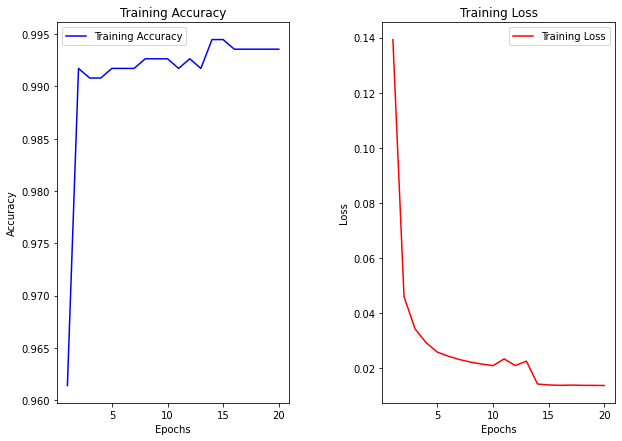

In [18]:
import matplotlib.pyplot as plt

def plot_training_process(acc_list, loss_list):
    epochs = range(1, len(acc_list) + 1)
    plt.figure(figsize=(10, 7))
    # 绘制准确率曲线
    plt.subplot(121)
    plt.plot(epochs, acc_list, 'b-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制损失函数曲线
    plt.subplot(122)
    plt.plot(epochs, loss_list, 'r-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 调整子图间距
    plt.subplots_adjust(wspace=0.4)

    # 显示图像
    plt.show()

# 调用函数绘制训练过程图
plot_training_process(acc_list, loss_list)


### **模型推理**
在模型推理阶段，我们提供了两种预测推理方式：单张图片推理和数据集推理方式

#### **加载模型**
首先加载训练好了的最佳模型权重。

In [19]:
import matplotlib.pyplot as plt

num_class = 12  # 
net = resnet50(num_class)
best_ckpt_path = 'BestCheckpoint/resnet50-best.ckpt'
# 加载模型参数
param_dict = ms.load_checkpoint(best_ckpt_path)
ms.load_param_into_net(net, param_dict)
model = ms.Model(net)
image_size = 224
workers = 1

#### **通过传入图片路径进行推理**
给定单张图片的路径推理预测分类结果

In [20]:
def predict_one(input_img):
    # 加载验证集的数据进行验证
    dataset_one = create_dataset_zhongyao(dataset_dir=input_img,
                                       usage="test",
                                       resize=image_size,
                                       batch_size=1,
                                       workers=workers)
    data = next(dataset_one.create_tuple_iterator())
    # print(data)
    images = data[0].asnumpy()
    labels = data[1].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data[0]))
    pred = np.argmax(output.asnumpy(), axis=1)
    # print(f'预测结果：{index_label_dict[pred[0]]}')
    return index_label_dict[pred[0]]

In [21]:
input_img = "dataset1/zhongyiyao/train/sz_tg/IMG_6002.JPG"
print(predict_one(input_img))

sz_tg


#### **通过传入测试数据集进行推理**
直接给定测试数据集，模型将对数据集中的样本进行预测，并生成可视化展示来呈现推理结果。

In [22]:
def visualize_model(dataset_test):
    # 加载验证集的数据进行验证
    data = next(dataset_test.create_tuple_iterator())
    # print(data)
    images = data[0].asnumpy()
    labels = data[1].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data[0]))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}  actual:{}'.format(index_label_dict[pred[i]],index_label_dict[labels[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


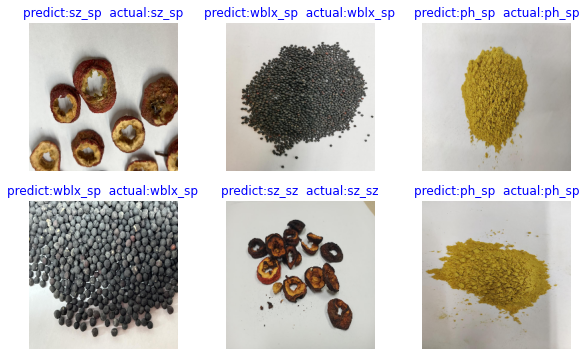

In [23]:
visualize_model(dataset_val)

### **参考文献**
[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).